In [3]:
%pylab inline
import numpy as np
import random

Populating the interactive namespace from numpy and matplotlib


We assume a constant volatility in a geometric Brownian motion setting

## Problem 1: American ?Digital Call (50 points)

To really understand how LSMC works, you need to implement it yourself. An implementation is given in the lecture, but to have a working knowledge of how it works, you'll need to rewrite your own code based on the code provided.

Refactor the code in the lecture in a class called Lsmc and which takes the payoff/intrinsic of the option as a lambda function upon initialization. Rename the variables of the code in a more meaningful way.

Then price an American digital call option (i.e. payoff is $1\{S_T \geq K\})$) using LSMC, assuming:
* option strike: $K = 100$
* continuously compounded discount rate $r = 0.02$
* continuous dividend yield is $y = 0.1$
* stock volatility $\sigma = 0.25$
* option expiry: $T = 1Y$

You need to produce the following outputs:
1. European and American option prices and their ratios for spot values between 50 and 150.
2. Exercise boundary of the american digital call.

In [9]:
class GBM(object):

    def __init__(self, r, y, vol):
        self.r = r
        self.y = y
        self.vol = vol

    def draw(self, sims, x0, dt):
        """sims is assumed to have a dimension of [npath, nd]"""
        xs = []
        x = np.ones(len(sims)) * np.log(x0)
        for sim in sims.T:
            x = x + (self.r -self.y - 0.5 * self.vol * self.vol) * dt + self.vol * sim * np.sqrt(dt)
            xs.append(x)
        else:
            return np.exp(np.array(xs).T)

In [4]:
K=100
payoff_func_d = lambda x: np.greater(x,K)

In [11]:
# European call pricing
def mc_eurocall(spath, r, T ,payoff_func):
    ev = payoff_func(spath[:,-1]) 
    discount = np.exp((-r)*T)
    cv = discount*ev 
    return mean(cv)

In [12]:
# American call pricing 
def fit_u(s, cv, ev):
    """
    cv = y
    only consider s with ev >0
    s form 1,s,s^2 matrix xs = A
    """
    itm_idx = np.greater(ev, 0)
    xs = np.array([np.ones(len(s)), s, s * s])
    a = xs.T[itm_idx, :]
    cs = np.linalg.pinv(a.T @ a) @ (a.T) @ (cv[itm_idx])
    return lambda x: cs @ (np.array([np.ones(len(x)), x, x * x]))


def fit_ex(s, cv, ev):
    # judge if exercise by compare cv and ev
    u = fit_u(s, cv, ev)
    return np.greater(ev, np.maximum(0, u(s)))


def opt_ex(s, cv, ev):
    idx = np.greater(ev, 0)
    evs, cvs = list(zip(*sorted((zip(ev[idx], cv[idx])), reverse=True)))
    cumev = np.cumsum(evs)[:-1]
    cumcvs = np.cumsum(cvs[::-1])[-2::-1]
    total = cumev + cumcvs
    oidx = np.argmax(total)
    return np.greater(ev, evs[oidx])


def exer_b(ev, exer):
    exed = ev[exer]
    if exed.size > 0:
        bidx = np.argmin(exed)
        return exed[bidx]
    return np.nan

def amer_opt(spath, disc1p, ex_f,payoff_func ):
    cvs = []
    cv = payoff_func(spath[:, -1])
    cvs.append(cv)
    
    exerb = [exer_b(cv, np.greater(cv, 0))]
    for s in spath.T[-2::-1]:
        ev = payoff_func(s)
        exer = ex_f(s, cv, ev)
        cv = exer * ev + (1 - exer) * cv * disc1p
        exerb.append(exer_b(ev, exer))
        cvs.append(cv)
    else:
        return mean(cv), np.array(exerb[::-1])

In [20]:
# Initialization
T, m, r, vol, y = 1., 52, .02, .25, 0
npath = 10000
dt = T/m

random.seed(23)
rand_sam = np.random.normal(size=[npath, m]) 

s0_list = np.arange(50,151)  

In [21]:
gbm = GBM(r,y,vol)

In [22]:
spath = gbm.draw(rand_sam, 100, dt)

In [8]:

Euro = []
Ame = []
ratios = []
ex_bd = []
for s0 in s0_list:
    spath = gbm.draw(rand_sam, s0, dt)
    
    euro = mc_eurocall(spath,r,T,payoff_func_d )
    Euro.append(euro)
    
    ame = amer_opt(spath, np.exp((-r)*dt), fit_ex,payoff_func_d)
    Ame.append(ame[0])
    
    ratio = euro / ame[0]
    ratios.append(ratio)
    
    ex_bd.append(ame[1])

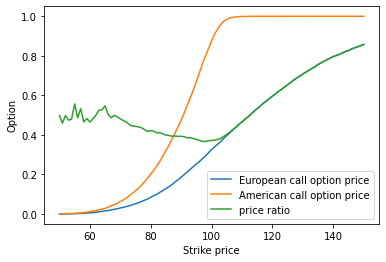

In [9]:
plt.plot(s0_list, np.array(Euro), label = "European call option price")
plt.plot(s0_list, np.array(Ame), label = "American call option price")
plt.plot(s0_list, np.array(ratios), label = "price ratio")
plt.legend()
plt.xlabel("Strike price")
plt.ylabel("Option")
plt.show()

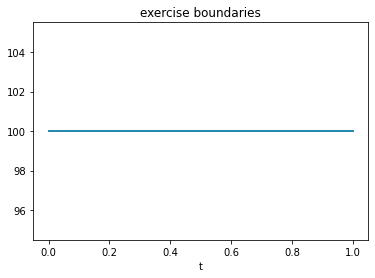

In [10]:
ts = np.linspace(0,T,m)
bdd = 100*np.ones(len(ts))
for i in range(len(ex_bd)):
     plt.plot(ts, bdd)
plt.xlabel("t")
plt.title("exercise boundaries")
plt.show()

For American option, will exercise it when Stock Price go over 100, so the exercise boundary here will always be 100.

## Problem 2: Call option with and without dividends (50 points)

Consider a dividend paying either:
* continuously with $q = 0.06$
* or a discrete dividend, paid once at time $t_d = 0.5$ and paying $D=6$, which means that $S_{t_d^+} = S_{t_d} - D$.

In the second case, we floor the stock at 0.05.

We want to price an American call option  using LSMC, assuming:
* option strike: $K = 100$
* continuously compounded discount rate $r = 0.02$
* stock volatility $\sigma = 0.25$
* option expiry: $T = 1Y$

You need to produce the following outputs:
1. Plot the difference between American and European price as the dividend increases:<p>
    a. $q$ ranging from 0.01 to 0.1.<p>
    b. $D$ ranging from 1 to 10.<p>



In [11]:
# parameters for stock price simulation
s0 = 100
K = 100
r = 0.02
q_ = np.linspace(0.01, 0.1, 10)
D_ = np.linspace(1, 10, 10)
vol = 0.25
T = 1

npath = 1000
m = 52
dt = T/m

payoff_func1 = lambda x: np.maximum(x-K, 0)
discount = np.exp(-r*dt)

random.seed(23)
rand_sam = np.random.normal(size=[npath, m]) 


In [12]:

EE = []
AA = []
diff_ = []

for q in q_:
    
    gbm1 = GBM(r, q, vol) 
    spath = gbm1.draw(rand_sam, s0, dt) 
    
    ee = mc_eurocall(spath, r, T, payoff_func1)
    EE.append(ee)
    
    aa = amer_opt(spath, np.exp((-r)*dt), fit_ex,payoff_func1)[0]
    AA.append(aa)
    
    diff = aa - ee
    diff_.append(diff)
    

In [13]:

EEE = []
AAA = []
difff_ = []

y = 0
gbm11 = GBM(r, y, vol) 
for D in D_:
    mid = int(m/2)
    fir = rand_sam[:, :mid]
    sec = rand_sam[:, mid:]
    spath_fir = gbm.draw(fir, s0, dt) 
    spath_sec = gbm.draw(sec, np.maximum(0.05, spath_fir[:,-1]-D), dt)
    spath = np.hstack([spath_fir, spath_sec])
    
    ee = mc_eurocall(spath, r, T, payoff_func1)
    EEE.append(ee)

    aa = amer_opt(spath, np.exp((-r)*dt), fit_ex,payoff_func1)[0]
    AAA.append(aa)

    diff = aa-ee
    difff_.append(diff)

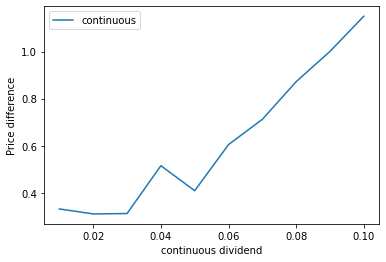

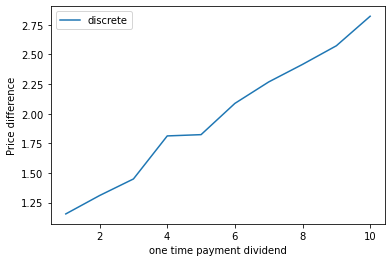

In [14]:
plt.plot(q_, diff_,  label = "continuous")
plt.legend()
plt.xlabel("continuous dividend")
plt.ylabel("Price difference")
plt.show()

plt.plot(D_, difff_,  label = "discrete")
plt.legend()
plt.xlabel("one time payment dividend")
plt.ylabel("Price difference")
plt.show()

2. We consider the case of continuous dividend and want to compute using LSMC the quantity:
$$ p = q \int_0^T E\left[\left(S_t - \frac{rK}{q} \right)^+ 1_{\{v(t,S_t) = H(S_t) \}} \right] dt $$

Compare the quantity $p$ to the early exercise premium (i.e. the price between the American and the European) for:<p>
    a. $q$ ranging from 0.01 to 0.1<p>
    b. $\sigma$ ranging from 0.1 to 0.3

In [15]:
# a
s0,K,r,vol,T = 100,100,0.02,0.25,1
q_ = np.linspace(0.01, 0.1, 10)

npath = 1000
m = 52
dt = T/m

discount = np.exp(-r*dt)
random.seed(23)
rand_sam = np.random.normal(size=[npath, m]) 

EEEE = []
AAAA = []
diffff_ = []
p_ = []

for q in q_:
    
    gbm = GBM(r, q, vol) # GBM simulation initialization with dividend
    spath = gbm.draw(rand_sam, s0, dt) 
    
    # European
    ee = mc_eurocall(spath,  r, T,payoff_func1)
    EEEE.append(ee)
    
    # American
    aa = amer_opt(spath, np.exp((-r)*dt), fit_ex,payoff_func1)
    AAAA.append(aa[0])
    
    # Early exercise premium
    diff = aa[0] - ee
    diffff_.append(diff)
    
    # p
    res = np.zeros(52)
    for price in spath:
        for i in range(52):
            listt = np.ones(52)
            if np.isnan(aa[1][i]):
                listt[i] = 0
            if price[i] < aa[1][i] + K:
                listt[i] = 0
        #exer = np.array([0 if np.isnan(aa[1][i]) else 1 for i in range(52)])
        res = res + np.maximum( price - r * K/q, 0) * listt /(52000)
    p = sum(res) * dt
    p_.append(p)

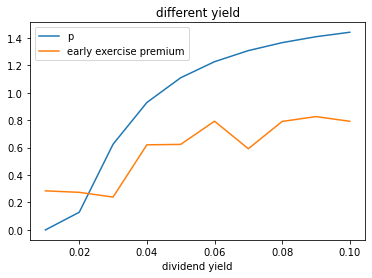

In [16]:
plt.plot(q_, p_, label = "p")
plt.plot(q_, diffff_, label = "early exercise premium")
plt.legend()
plt.xlabel("dividend yield")
plt.title('different yield')
plt.show()

In [17]:
# b

y = 0.06
vol_ = np.linspace(0.1, 0.3, 10)
s0,K,r,T = 100,100,0.02,1

npath = 1000
m = 52
dt = T/m

discount = np.exp(-r*dt)
random.seed(23)
rand_sam = np.random.normal(size=[npath, m]) 


EEEEE = []
AAAAA = []
difffff_ = []
p_ = []

for q in q_:
    
    gbm = GBM(r, q, vol) # GBM simulation initialization with dividend
    spath = gbm.draw(rand_sam, s0, dt) 
    
    # European
    ee = mc_eurocall(spath,  r, T,payoff_func1)
    EEEEE.append(ee)
    
    # American
    aa = amer_opt(spath, np.exp((-r)*dt), fit_ex,payoff_func1)
    AAAAA.append(aa[0])
    
    # Early exercise premium
    diff = aa[0] - ee
    difffff_.append(diff)
    
    # p
    res = np.zeros(52)
    for price in spath:
        for i in range(52):
            listt = np.ones(52)
            if np.isnan(aa[1][i]):
                listt[i] = 0
            if price[i] < aa[1][i] + K:
                listt[i] = 0
        #exer = np.array([0 if np.isnan(aa[1][i]) else 1 for i in range(52)])
        res = res + np.maximum( price - r * K/q, 0) * listt /(52000)
    p = sum(res) * dt
    p_.append(p)

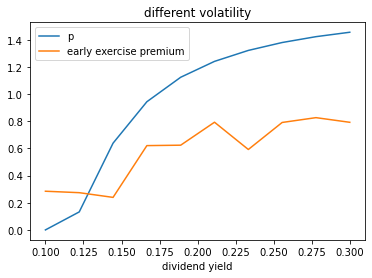

In [18]:
plt.plot(vol_, p_, label = "p")
plt.plot(vol_, diffff_, label = "early exercise premium")
plt.legend()
plt.title('different volatility')
plt.xlabel("dividend yield")
plt.show()